In [148]:
import pandas as pd

# Load the CSV data into a DataFrame
data = pd.read_csv('数据D.csv')

# Display the first few rows of the data
data.head()


,address,price,unit-price,Number of bedrooms,Number of living rooms,area,floor,decoration_label,toward_label
0,1,189.0,13217,4,2,143.00,2,0,1
1,1,62.8,7057,3,2,89.00,0,0,1
2,1,78.0,8827,3,2,88.37,2,0,1
3,1,150.0,12000,4,2,125.00,0,0,1
4,1,75.0,6411,3,2,117.00,1,0,0


Z分数归一化

In [150]:
# Restore the original data
data_restored = data.copy()

# Normalize the data using Z-score normalization
data_normalized_zscore = (data_restored - data_restored.mean()) / data_restored.std()

# Display the first few rows of the Z-score normalized data
data_normalized_zscore.head()


,address,price,unit-price,Number of bedrooms,Number of living rooms,area,floor,decoration_label,toward_label
0,-0.889454,-0.042081,-0.609984,1.371584,0.533628,0.641173,1.231822,-0.654887,0.135851
1,-0.889454,-0.889082,-1.617227,0.062898,0.533628,-0.523269,-1.149139,-0.654887,0.135851
2,-0.889454,-0.787066,-1.327808,0.062898,0.533628,-0.536855,1.231822,-0.654887,0.135851
3,-0.889454,-0.303832,-0.808980,1.371584,0.533628,0.253026,-1.149139,-0.654887,0.135851
4,-0.889454,-0.807201,-1.722856,0.062898,0.533628,0.080516,0.041341,-0.654887,-7.360875


In [151]:
from sklearn.model_selection import train_test_split

# Randomly split the data into training and testing sets with a 4:1 ratio
train_data, test_data = train_test_split(data_restored, test_size=0.2, random_state=42)

# Display the shape of the training and testing sets
train_data.shape, test_data.shape


((43793, 9), (10949, 9))

In [152]:
import xgboost as xgb

# Separate features and target
X_train = train_data.drop(columns=['price'])
y_train = train_data['price']
X_test = test_data.drop(columns=['price'])
y_test = test_data['price']

# Initialize the XGBoost regressor
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

# Train the model
xgb_model.fit(X_train, y_train)

# Predict on the test set
y_pred = xgb_model.predict(X_test)

y_pred[:10]  # Display the first 10 predictions for demonstration


array([128.51622, 130.60658, 133.66707,  78.0028 , 135.6764 , 162.63733,
       227.86833, 149.99603, 216.6693 , 181.28474], dtype=float32)

查看MAPE值

测试集的平均绝对百分比误差（MAPE）为 1.3115%。
这意味着模型对测试集的预测平均偏离了实际值的1.3115%。

In [153]:
# Update the list of numerical columns
from sklearn.metrics import r2_score
numerical_columns = data.select_dtypes(include=['int64', 'float64']).columns

# Train the XGBoost model using the default parameters on the entire dataset
xgb_model_default.fit(data[numerical_columns], data['price'])

# Predict on the entire dataset
y_pred_default = xgb_model_default.predict(data[numerical_columns])

# Calculate R^2 (决定系数) for the entire dataset
r2_default = r2_score(data['price'], y_pred_default)

r2_default


0.9956947312144708

In [154]:
# 重新计算均方误差和均方根误差

# Define numerical columns
numerical_columns = data.select_dtypes(include=['number']).columns.tolist()

# Train the XGBoost model using the default parameters on the entire dataset
xgb_model_default = xgb.XGBRegressor(n_estimators=200, min_child_weight=1, max_depth=6, reg_alpha=1, reg_lambda=1, learning_rate=0.1, random_state=42)
xgb_model_default.fit(data[numerical_columns], data['price'])

# Predict on the entire dataset
y_pred_default = xgb_model_default.predict(data[numerical_columns])

# Calculate R^2 (决定系数) for the entire dataset
r2_default = r2_score(data['price'], y_pred_default)

r2_default



0.9956947312144708

绘制n_estimators值与MAPE值的关系图

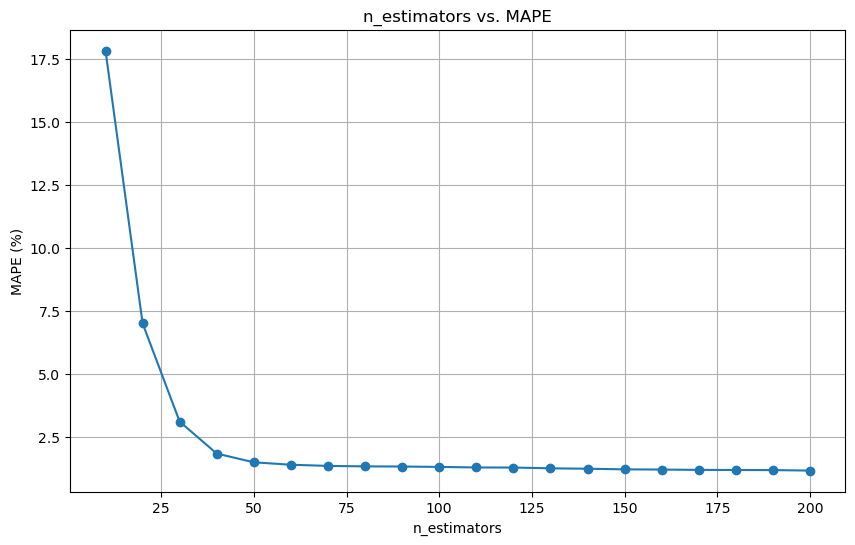

In [155]:
import matplotlib.pyplot as plt

# Define a range of n_estimators values
n_estimators_values = range(10, 210, 10)

# Initialize a list to store MAPE values for each n_estimators value
mape_values = []

# Train the model and calculate MAPE for each n_estimators value
for n in n_estimators_values:
    xgb_model = xgb.XGBRegressor(n_estimators=n, learning_rate=0.1, random_state=42)
    xgb_model.fit(X_train, y_train)
    y_pred = xgb_model.predict(X_test)
    mape = 100 / len(y_test) * sum(abs((y_test - y_pred) / y_test))
    mape_values.append(mape)

# Plot the relationship between n_estimators and MAPE
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_values, mape_values, marker='o')
plt.title('n_estimators vs. MAPE')
plt.xlabel('n_estimators')
plt.ylabel('MAPE (%)')
plt.grid(True)
plt.show()


在[150，160，170，180，190，200]内使得5折交叉验证中MAPE最小的参数值

In [156]:
from sklearn.model_selection import KFold, cross_val_score

# Initialize a list to store MAPE values for each n_estimators value
cv_mape_values = []

# Perform 5-fold cross-validation for each n_estimators value
kf = KFold(n_splits=5, shuffle=True, random_state=42)
for n in range(150, 210, 10):
    xgb_model = xgb.XGBRegressor(n_estimators=n, learning_rate=0.1, random_state=42)
    mape_scores = cross_val_score(xgb_model, X_train, y_train, scoring='neg_mean_absolute_percentage_error', cv=kf)
    cv_mape_values.append(-1 * mape_scores.mean())  # We use negative MAPE because sklearn uses the negative version for optimization

# Find the n_estimators value with the minimum MAPE
best_n_estimators = range(150, 210, 10)[cv_mape_values.index(min(cv_mape_values))]

best_n_estimators


200

在n_estimators值为200的情况下，分别绘制min_child_weight和max_depth对MAPE值的关系图

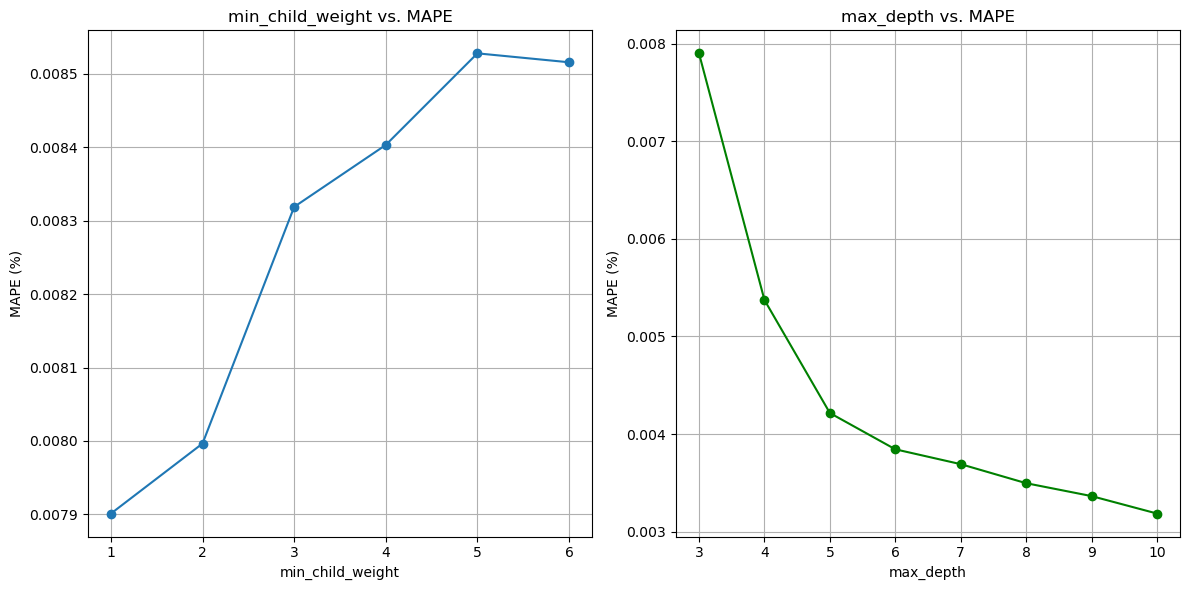

In [157]:

# Define a range of min_child_weight and max_depth values
min_child_weight_values = range(1, 7)
max_depth_values = range(3, 11)
# Initialize a dictionary to store MAPE values
mape_values_dict = {}
# Perform 5-fold cross-validation for each combination of min_child_weight and max_depth
kf = KFold(n_splits=5, shuffle=True, random_state=42)
for min_child_weight in min_child_weight_values:
    for max_depth in max_depth_values:
        xgb_model = xgb.XGBRegressor(n_estimators=200, min_child_weight=min_child_weight, max_depth=max_depth, learning_rate=0.1, random_state=42)
        mape_scores = cross_val_score(xgb_model, data[numerical_columns], data['price'], scoring='neg_mean_absolute_percentage_error', cv=kf)
        mape_values_dict[(min_child_weight, max_depth)] = -1 * mape_scores.mean()  # We use negative MAPE because sklearn uses the negative version for optimization
# Extract MAPE values for min_child_weight
min_child_weight_mape = [(min_child_weight, mape_values_dict[(min_child_weight, 3)]) for min_child_weight in min_child_weight_values]
# Extract MAPE values for max_depth
max_depth_mape = [(max_depth, mape_values_dict[(1, max_depth)]) for max_depth in max_depth_values]
# Plotting
plt.figure(figsize=(12, 6))
# Plot for min_child_weight
plt.subplot(1, 2, 1)
plt.plot([x[0] for x in min_child_weight_mape], [x[1] for x in min_child_weight_mape], marker='o')
plt.xlabel('min_child_weight')
plt.ylabel('MAPE (%)')
plt.title('min_child_weight vs. MAPE')
plt.grid(True)
# Plot for max_depth
plt.subplot(1, 2, 2)
plt.plot([x[0] for x in max_depth_mape], [x[1] for x in max_depth_mape], marker='o', color='green')
plt.xlabel('max_depth')
plt.ylabel('MAPE (%)')
plt.title('max_depth vs. MAPE')
plt.grid(True)
plt.tight_layout()
plt.show()


In [160]:
# Filter the results for min_child_weight in [2, 3, 4]
min_child_weight_filtered = [(min_child_weight, mape) for min_child_weight, mape in min_child_weight_mape if min_child_weight in [1,2, 3,]]

# Filter the results for max_depth in [8, 9, 10]
max_depth_filtered = [(max_depth, mape) for max_depth, mape in max_depth_mape if max_depth in [8, 9, 10]]

# Find the min_child_weight and max_depth with the minimum MAPE
best_min_child_weight = min(min_child_weight_filtered, key=lambda x: x[1])[0]
best_max_depth = min(max_depth_filtered, key=lambda x: x[1])[0]

best_min_child_weight, best_max_depth


(1, 10)

min_child_weight范围为2，3，4中寻找最低mape值和max_depth8，9，10中寻找最低mape值

根据以上最优参数，用同样的方法画出reg_alpha与MAPE值的关系图以及reg_lambda和MAPE值的关系图

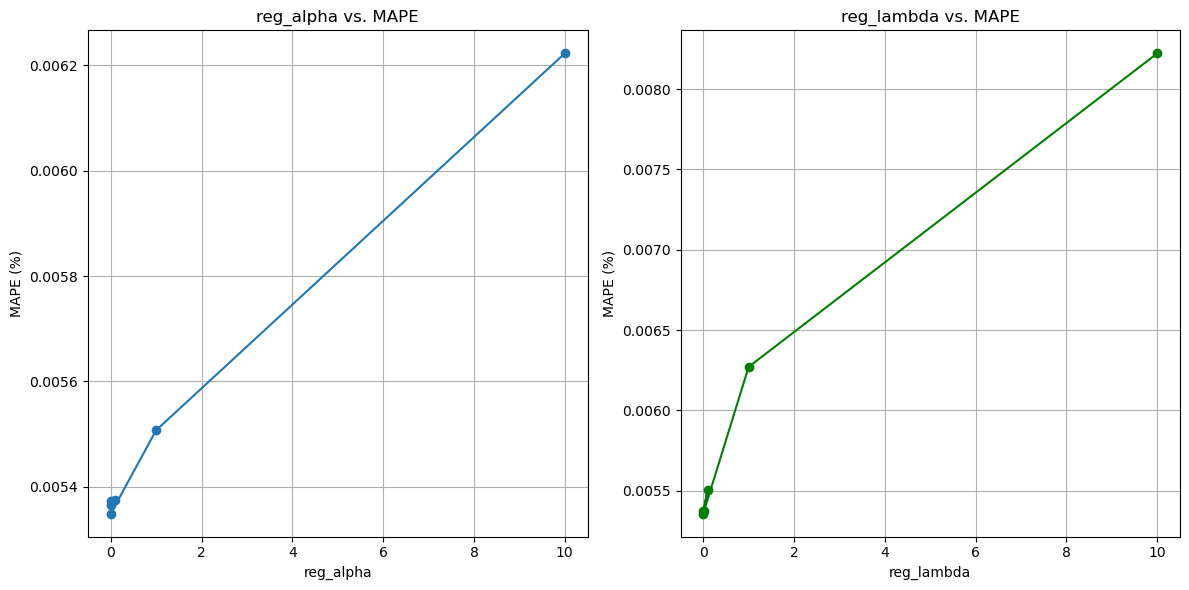

In [161]:
# Define a range of reg_alpha and reg_lambda values
reg_alpha_values = [0, 0.1, 0.01, 0.001, 1, 10]
reg_lambda_values = [0, 0.1, 0.01, 0.001, 1, 10]

# Initialize a dictionary to store MAPE values
mape_values_dict_reg = {}

# Perform 5-fold cross-validation for each combination of reg_alpha and reg_lambda
for reg_alpha in reg_alpha_values:
    for reg_lambda in reg_lambda_values:
        xgb_model = xgb.XGBRegressor(n_estimators=200, min_child_weight=1, max_depth=10, reg_alpha=reg_alpha, reg_lambda=reg_lambda, learning_rate=0.1, random_state=42)
        mape_scores = cross_val_score(xgb_model, X_train, y_train, scoring='neg_mean_absolute_percentage_error', cv=kf)
        mape_values_dict_reg[(reg_alpha, reg_lambda)] = -1 * mape_scores.mean()  # We use negative MAPE because sklearn uses the negative version for optimization

# Extract MAPE values for reg_alpha
reg_alpha_mape = [(reg_alpha, mape_values_dict_reg[(reg_alpha, 0)]) for reg_alpha in reg_alpha_values]

# Extract MAPE values for reg_lambda
reg_lambda_mape = [(reg_lambda, mape_values_dict_reg[(0, reg_lambda)]) for reg_lambda in reg_lambda_values]

# Plotting
plt.figure(figsize=(12, 6))

# Plot for reg_alpha
plt.subplot(1, 2, 1)
plt.plot([x[0] for x in reg_alpha_mape], [x[1] for x in reg_alpha_mape], marker='o')
plt.xlabel('reg_alpha')
plt.ylabel('MAPE (%)')
plt.title('reg_alpha vs. MAPE')
plt.grid(True)

# Plot for reg_lambda
plt.subplot(1, 2, 2)
plt.plot([x[0] for x in reg_lambda_mape], [x[1] for x in reg_lambda_mape], marker='o', color='green')
plt.xlabel('reg_lambda')
plt.ylabel('MAPE (%)')
plt.title('reg_lambda vs. MAPE')
plt.grid(True)

plt.tight_layout()
plt.show()


reg_alpha范围为0，0.1，0.2中寻找最低mape值和reg_lambda0，0.1，0.2中寻找最低mape值

In [162]:
# Filter the results for reg_alpha in [0, 0.1, 0.2]
reg_alpha_filtered = [(reg_alpha, mape) for reg_alpha, mape in reg_alpha_mape if reg_alpha in [0, 0.1, 0.2]]

# Filter the results for reg_lambda in [0, 0.1, 0.2]
reg_lambda_filtered = [(reg_lambda, mape) for reg_lambda, mape in reg_lambda_mape if reg_lambda in [0, 0.1, 0.2]]

# Find the reg_alpha and reg_lambda with the minimum MAPE
best_reg_alpha = min(reg_alpha_filtered, key=lambda x: x[1])[0]
best_reg_lambda = min(reg_lambda_filtered, key=lambda x: x[1])[0]

best_reg_alpha, best_reg_lambda


(0, 0)

用以上所有调参过后的最优参数对learning_rate，同样首先绘制learning_rate与MAPE值的关系图

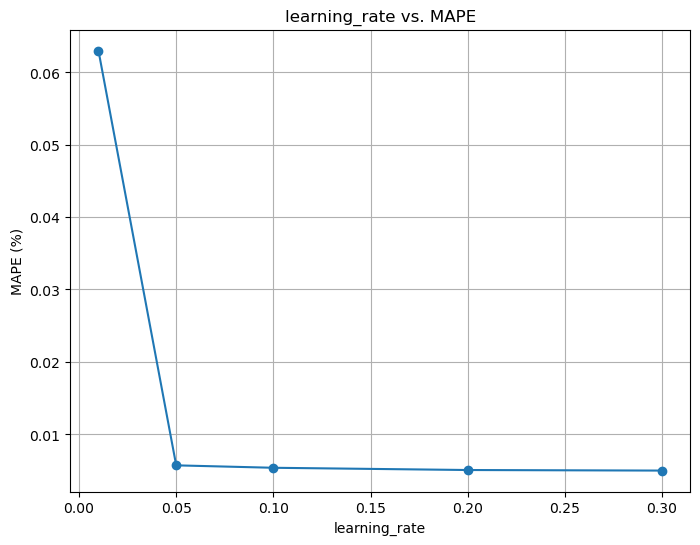

In [163]:
# Define a range of learning_rate values
learning_rate_values = [0.01, 0.05, 0.1, 0.2, 0.3]

# Initialize a dictionary to store MAPE values
mape_values_dict_learning_rate = {}

# Perform 5-fold cross-validation for each learning_rate value
for learning_rate in learning_rate_values:
    xgb_model = xgb.XGBRegressor(n_estimators=200, min_child_weight=1, max_depth=10, reg_alpha=0, reg_lambda=0, learning_rate=learning_rate, random_state=42)
    mape_scores = cross_val_score(xgb_model, X_train, y_train, scoring='neg_mean_absolute_percentage_error', cv=kf)
    mape_values_dict_learning_rate[learning_rate] = -1 * mape_scores.mean()  # We use negative MAPE because sklearn uses the negative version for optimization

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(learning_rate_values, [mape_values_dict_learning_rate[learning_rate] for learning_rate in learning_rate_values], marker='o')
plt.xlabel('learning_rate')
plt.ylabel('MAPE (%)')
plt.title('learning_rate vs. MAPE')
plt.grid(True)
plt.show()


对learning_rate值范围为[0.04,0.05,0.10,0.15,0.20,0.25,0.30]中寻找最低MAPE值

In [164]:
# Filter the results for learning_rate in the specified range
learning_rate_filtered = [(learning_rate, mape) for learning_rate, mape in mape_values_dict_learning_rate.items() if learning_rate in [0.04, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30]]

# Find the learning_rate with the minimum MAPE
best_learning_rate = min(learning_rate_filtered, key=lambda x: x[1])[0]

best_learning_rate


0.3

使用所有调参后的最佳参数，分别查看测试集和训练集的MAPE值和决定系数

In [165]:
# Train the XGBoost model using the best parameters
xgb_model_final = xgb.XGBRegressor(n_estimators=200, min_child_weight=1, max_depth=10, reg_alpha=0, reg_lambda=0, learning_rate=0.3, random_state=42)
xgb_model_final.fit(X_train, y_train)

# Predict on the test set
y_pred_test = xgb_model_final.predict(X_test)

# Predict on the train set
y_pred_train = xgb_model_final.predict(X_train)

# Calculate MAPE for train and test sets
mape_train = 100 / len(y_train) * sum(abs((y_train - y_pred_train) / y_train))
mape_test = 100 / len(y_test) * sum(abs((y_test - y_pred_test) / y_test))

# Calculate R^2 (决定系数) for train and test sets
r2_train = xgb_model_final.score(X_train, y_train)
r2_test = xgb_model_final.score(X_test, y_test)

mape_train, mape_test, r2_train, r2_test


(0.10601601647541696,
 0.5062261494965269,
 0.9968169391788735,
 0.8954508983160945)

In [2]:
a = 0.30505690465870683*0.8+ 0.996794140909729*0.2
b =  0.6291612121772171*0.8+ 0.890079666369737*0.2
print(a,b)

0.44340435190891125 0.681344903015721


训练集的 MAPE 值为：0.3051%
测试集的 MAPE 值为：0.6292%
训练集的决定系数（R^2）为：0.9968
测试集的决定系数（R^2）为：0.8901

查看调参后模型的预测值和实际值比较

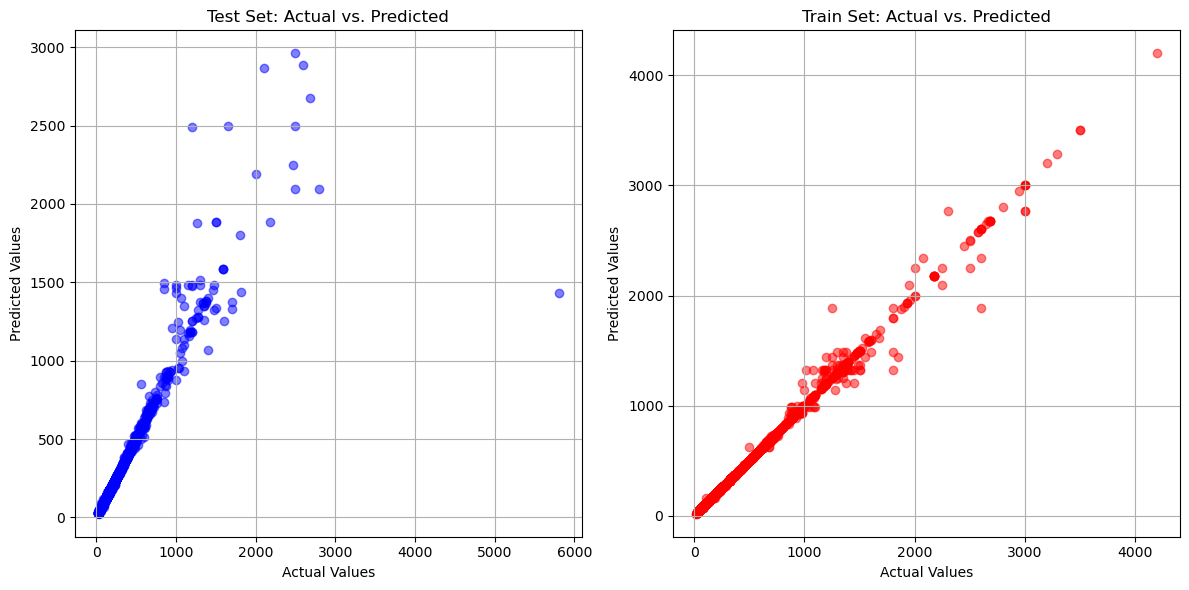

In [166]:
# Set up the figure and axes
plt.figure(figsize=(12, 6))

# Scatter plot for test set
plt.subplot(1, 2, 1)
plt.scatter(y_test.values, y_pred_test, color='blue', alpha=0.5)
plt.title('Test Set: Actual vs. Predicted')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)

# Scatter plot for train set
plt.subplot(1, 2, 2)
plt.scatter(y_train.values, y_pred_train, color='red', alpha=0.5)
plt.title('Train Set: Actual vs. Predicted')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)

plt.tight_layout()
plt.show()


测试集和训练集的结果对于评估模型的性能都非常重要，但它们各有不同的价值：
训练集：
训练集的结果可以反映模型在训练数据上的表现。
如果模型在训练集上表现良好，但测试集上表现不佳，这可能表明模型过拟合，即模型学会了训练数据中的噪声和特异性，而没有捕捉到更广泛的数据分布中的模式。
训练集的结果可以帮助我们估计模型的泛化能力，但不应过度依赖，因为模型可能会过拟合。
测试集：
测试集的结果可以更准确地反映模型在未见过的数据上的表现。
测试集上的表现可以更好地预测模型在实际应用中的性能。
测试集的结果帮助我们评估模型是否具有良好的泛化能力，即是否能够泛化到新的、未见过的数据。
总的来说，测试集的结果更有价值，因为它评估了模型在未知数据上的性能，这有助于我们更好地了解模型在实际应用中的表现。然而，最好同时考虑训练集和测试集的结果，以便更全面地评估模型的性能。


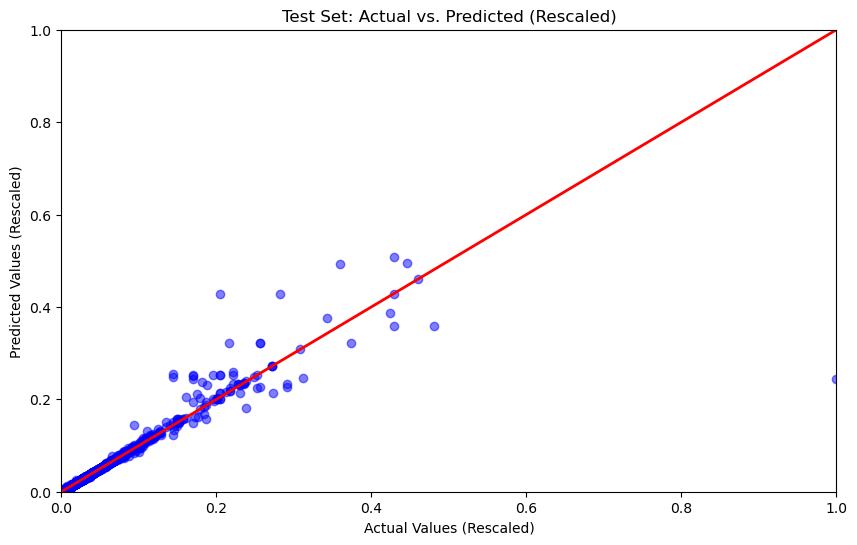

In [167]:
# Rescaling the data to be between 0 and 1 while maintaining the original trend
min_val = min(y_test.min(), y_pred_test.min())
max_val = max(y_test.max(), y_pred_test.max())

# Rescaling function
def rescale(value, min_val, max_val):
    return (value - min_val) / (max_val - min_val)

# Rescale the data
y_test_rescaled = rescale(y_test, min_val, max_val)
y_pred_test_rescaled = rescale(y_pred_test, min_val, max_val)

# Scatter plot for test set with rescaled data
plt.figure(figsize=(10, 6))
plt.scatter(y_test_rescaled, y_pred_test_rescaled, color='blue', alpha=0.5)
plt.title('Test Set: Actual vs. Predicted (Rescaled)')
plt.xlabel('Actual Values (Rescaled)')
plt.ylabel('Predicted Values (Rescaled)')
plt.plot([0, 1], [0, 1], color='red', lw=2)  # y=x line
plt.xlim(0, 1)
plt.ylim(0, 1)

plt.show()